# Librearies

In [1]:
import os
import sys
import json
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.stats import wasserstein_distance

In [3]:
sys.path.append(os.path.abspath(os.path.join('..'))) 

In [4]:
from models.vanilla_gan import Vanilla_GAN, Vanilla_Discriminator, Vanilla_Generator
from models.meta_vae import Meta_VAE, Meta_Encoder, Meta_Decoder
from models.smvae import Base_VAE, Base_Encoder, Base_Decoder
from models.marginal_vae import VAE, Encoder, Decoder
from models.vanilla_vae import Vanilla_VAE, Vanilla_Encoder, Vanilla_Decoder

In [5]:
device = torch.device('cpu')

# Utils

In [6]:
def not_trainable(model):
    for param in model.parameters():
        param.requires_grad = False

In [7]:
def load_models(n,models_path):
    models_list = []
    for i in range(n):
        for f in os.listdir(models_path):
            filename = os.fsdecode(f)
            if filename.endswith("_{}".format(i)):
                load_path = os.path.join(models_path,filename)
                model = torch.load(load_path,map_location = device)
                print(filename)
                not_trainable(model)
                models_list.append(model)
    return models_list

# Use Case

<div style="text-align: center;">
  <img src="../figures/use_case.png" alt="Use case" width="600" height="400">
</div>

# Dataset 
<div style="text-align: center;">
  <img src="../figures/dataset_sample.PNG" alt="Dataset Sample" width="600" height="400">
</div>

## Load datasets

In [8]:
data_dir  = "../datasets/meta/experiments"

In [9]:
class Meta_Dataset(Dataset,):
    def __init__(self,dataset,h_param,d_int,d_ext,is_vvae = False):
        self.is_vvae = is_vvae
        self._dataset = dataset.float()
        self._h_param = h_param.float()
        self._d_int = d_int.float()
        self._d_ext = d_ext.float()
    def __len__(self):
        return len(self._h_param)
    def __getitem__(self,idx):
        data = self._dataset[idx]
        h_param = self._h_param[idx]
        d_int = self._d_int[idx]
        d_ext = self._d_ext[idx]
        if self.is_vvae:
            data = torch.cat((data,d_int,d_ext),1)
            return data,h_param
        return data, h_param, d_int, d_ext

In [10]:
def to_tensor(arr):
    tensor_data = torch.tensor(arr)
    return torch.cat((torch.unsqueeze(tensor_data[:,:,0],1),torch.unsqueeze(tensor_data[:,:,1],1)),1).float()

def get_hyperparams(path):
    dataset = pd.read_csv(os.path.join(path,'dataset'))
    xs = np.array(dataset.x)
    ys = np.array(dataset.y)
    masses = np.array(dataset.m_cube)
    masses = torch.unsqueeze(torch.tensor(masses),1)
    xs = torch.unsqueeze(torch.tensor(xs),1)
    ys = torch.unsqueeze(torch.tensor(ys),1)
    return torch.cat((masses,xs,ys),1)

def get_cylinders(path):
    int_path  = os.path.join(path,'int_cylinder.npy')
    ext_path  = os.path.join(path,'ext_cylinder.npy')

    with open(int_path, 'rb') as f:
        int_cylinder = np.load(f)
    with open(ext_path, 'rb') as f:
        ext_cylinder = np.load(f)
        
    ext_tensor_cylinders, int_tensor_cylinders =  to_tensor(ext_cylinder),to_tensor(int_cylinder)
    return torch.cat(( int_tensor_cylinders, ext_tensor_cylinders),2)

def get_circular_densities(path):
    int_path = os.path.join(path,'int_density.npy')
    ext_path = os.path.join(path,'ext_density.npy')
    
    with open(int_path, 'rb') as f:
        int_density = np.load(f)
    with open(ext_path, 'rb') as f:
        ext_density = np.load(f)
            
        return to_tensor(int_density), to_tensor(ext_density)

In [11]:
def get_experiments_loader(is_vvae = False,batch_size = 20000):    
    hp = get_hyperparams(data_dir)
    # get cylinders
    cylinders = get_cylinders(data_dir)
        # get densities
    int_densities,ext_densities = get_circular_densities(data_dir)
        # train/val sets
    test_set = Meta_Dataset(cylinders, hp, int_densities, ext_densities,is_vvae)
    out_dataloader = DataLoader(test_set, batch_size =20000)
    return out_dataloader

In [12]:
test_dataloader = get_experiments_loader()
vvae_test_loader = get_experiments_loader(True) # Vanilla VAE (vvae) AND Vanilla GAN (gan) dataloaders

# Marginal models

## Marginal VAEs 

In [13]:
density_vae = torch.load('../saves/marginal_vae/density_vae',map_location=torch.device(device))
cylinder_vae = torch.load('../saves/marginal_vae/cylinder_vae',map_location=torch.device(device))

In [14]:
not_trainable(density_vae)
not_trainable(cylinder_vae)

# Meta Models

## Vanilla GAN

In [15]:
gan_path = os.path.join("../saves","vanilla_gan")

In [16]:
gan_list = load_models(5,gan_path)

gan_lt4_0
gan_lt4_1
gan_lt4_2
gan_lt4_3
gan_lt4_4


## Vanilla VAE

In [17]:
vvae_path = os.path.join("../saves","vanilla_vae")

In [18]:
vvae_list = load_models(5,vvae_path)

vvae_lt_4_0
vvae_lt_4_1
vvae_lt_4_2
vvae_lt_4_3
vvae_lt_4_4


## SMVAE

<div style="text-align: center;">
  <img src="../figures/smvae.PNG" alt="SMVAE architecture" width="600" height="400">
</div>

### Load SMVAE models

In [19]:
svae_path = os.path.join("../saves","smvae")

In [20]:
svae_list = load_models(5,svae_path)

svae_lt_4_0
svae_lt_4_1
svae_lt_4_2
svae_lt_4_3
svae_lt_4_4


## Meta VAE 

<div style="text-align: center;">
  <img src="../figures/meta_vae.PNG" alt="Meta-VAE architecture" width="600" height="400">
</div>


### Load Meta-VAE models

In [21]:
mvae_path = os.path.join("../saves","meta_vae")

In [22]:
mvae_list = load_models(5,mvae_path)

mvae_lt_4_0
mvae_lt_4_1
mvae_lt_4_2
mvae_lt_4_3
mvae_lt_4_4


# Experiments

In [23]:
n_models = 5
latent_dim=4

In [24]:
all_models_dict = {'gan':gan_list,'vvae':vvae_list,'svae':svae_list, 'mvae': mvae_list}
model_name = {'gan':'Vanilla GAN','vvae':'Vanilla VAE','mvae':'Meta-VAE','svae':'SMVAE'}

## Useful fcts

### Functions to compute and plot the equilibrium and contact constraints verification

In [25]:
def equ(r1,r2,d1,d2,h):
    m = h[:,0]
    x = h[:,1]
    y = h[:,2]
    d1 = d1[:,0,0]
    d2 = d2[:,0,0]
    ri1=r1[:,0,0]
    re1=r1[:,0,30]
    ri2=r2[:,0,0]
    re2=r2[:,0,30]
    s1=torch.pi*(re1**2-ri1**2)
    s2=torch.pi*(re2**2-ri2**2)
    m1 = s1*d1/1000 
    m2 = s2*d2/1000
    return (m1+m2)*x-m*y,re2-ri1,re1,ri1,re2,ri2,d2,d1,(m1+m2)*x,m*y

In [26]:
def generate_multiple(model_list,model_type,latent_dim=latent_dim,unifs=None,loader = test_dataloader):
    output_dict = {'error':[],'r_err':[],'re1':[],'ri1':[],'re2':[],'ri2':[],'d2':[],'d1':[],'mx':[],'my':[]}
    
    '''sampling stratedgy'''
    if unifs==None:
        unifs = [None]*len(model_list)
    else:
        if model_type  in ['vvae','gan']:
            loader = vvae_test_loader
        
        
    '''next iteration'''
    if model_type  in ['vvae','gan']:
        data,h = next(iter(loader))
        c,d_int,d_ext = data[:,:,:120],data[:,:,120:150],data[:,:,150:]
    else:
        c, h,d_int,d_ext = next(iter(loader))
    h = h.to(device)
    
    
    '''generations list'''
    int_gens,ext_gens,di_gens,de_gens =  [],[],[],[]
    
    
    '''latent and generation'''
    i=-1
    for model,unif in zip(model_list,unifs):
        i+=1
        if unif !=None:
            latent = torch.rand((h.shape[0],latent_dim))*(2*unif)-unif
        else:
            latent = torch.randn(h.shape[0],latent_dim)
        latent = latent.to(device)
        
        if model_type == 'vvae':
            recon = model._decoder(latent,h)
            int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
        elif model_type == 'gan':
            recon = model(latent,h)
            int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
        elif model_type == 'svae':
            int_gen,ext_gen,di_gen,de_gen = model._decoder(latent,h)
        else:
            z_int, z_ext, zdi,zde = model._decoder(latent,h)
            int_gen = cylinder_vae._decoder(z_int)
            ext_gen =  cylinder_vae._decoder(z_ext)
            di_gen= density_vae._decoder(zdi)
            de_gen= density_vae._decoder(zde)
            
        int_gen = int_gen.cpu().detach().numpy()
        ext_gen = ext_gen.cpu().detach().numpy()
        di_gen = di_gen.cpu().detach().numpy()
        de_gen = de_gen.cpu().detach().numpy()
            
            
        h_param = torch.clone(h)
        h_param = torch.squeeze(h_param).detach().cpu().numpy()
        error,r_err,re1,ri1,re2,ri2,d2,d1,mx,my = equ(ext_gen,int_gen,de_gen,di_gen,h_param)
        output_dict['error'].append(error)
        output_dict['r_err'].append(r_err)
        output_dict['re1'].append(re1)
        output_dict['ri1'].append(ri1)
        output_dict['re2'].append(re2)
        output_dict['ri2'].append(ri2)
        output_dict['d2'].append(d2)
        output_dict['d1'].append(d1)
        output_dict['mx'].append(mx)
        output_dict['my'].append(my)
    c = c.numpy()
    c_int,c_ext = c[:,:,:60],c[:,:,60:]
    output_dict['real_ri2']=c_int[:,0,0]
    output_dict['real_re2']=c_int[:,0,30]
    output_dict['real_ri1']=c_ext[:,0,0]
    output_dict['real_re1']=c_ext[:,0,30]
    output_dict['real_d2'] = d_int[:,0,0].detach().cpu().numpy()
    output_dict['real_d1'] = d_ext[:,0,0].detach().cpu().numpy()
    output_dict['h_param'] = h_param
    return output_dict

In [27]:
def plot_errors():
    unifs_dico = {'gan':.1,'mvae':.1,'svae':.1,'vvae':.1}# 
    all_errors = {}
    for k,v in all_models_dict.items():
        all_errors[k] = generate_multiple(v,k,unifs=[unifs_dico[k] for i in range(n_models)])
    fig, ax = plt.subplots(figsize = (20,10),nrows=3, ncols=4)
    i=0
    for k,v in tqdm(all_errors.items()):
        err = np.reshape(np.array(v['error']),(1,-1))[0,:]
        r_err = np.reshape(np.array(v['r_err']),(1,-1))[0,:]
        ax[0][i].hist(err,bins=500)#,alpha = .2)
        ax[0][i].axvline(x = 0, color = 'r',linestyle='--')
        ax[0][i].set_title(model_name[k])
        xlim  = [-5000,5000] if k!='gan' else [-25000,25000]
        ax[0][i].set_xlim(xlim)
        
        ax[1][i].hist(r_err,bins=500)#,alpha = .2)
        ax[1][i].axvline(x = 0, color = 'r',linestyle='--')
        xlim  = [-2,2] if k!='gan' else [-50,50]
        ax[1][i].set_xlim(xlim)
        
        x=np.reshape(np.array(v['mx']),(1,-1))
        y=np.reshape(np.array(v['my']),(1,-1))
        ax[2][i].scatter(x[0,:],y[0,:])
        ax[2][i].axline((0, 0), slope=1,color='r')
        ax[2][0].set_xlabel(r'$x\times m_{generated}$')
        ax[2][0].set_ylabel(r'$y\times m_{cube}$')
        i+=1
    fig.suptitle(r'Histograms of $E_p$ and $E_c$ and residual plots of $E_p$')
    plt.show()

In [28]:
def plot_box_plots(whis=1.5,linthresh=None):
    bound = .1
    all_errors = {}
    for k,v in all_models_dict.items():
        all_errors[k] = generate_multiple(v,k,unifs=[bound for i in range(n_models)])
    model_types = list(all_errors.keys())
    
    fig, ax = plt.subplots(figsize = (20,10),nrows=1, ncols=2)
    err = [np.concatenate(all_errors[model_type]['error']) for model_type in model_types]
    ax[0].boxplot(err, whis=whis,showfliers=False, labels=[model_name[m] for m in model_types])
    ax[0].set_xlabel('Model Types')
    ax[0].set_ylabel(r'$E_p$')
    ax[0].set_title(r'Box Plot of $E_p$ for Different Model Types')
    if linthresh:
        ax[0].set_yscale('symlog',linthresh=linthresh[0])     
    err = [np.concatenate(all_errors[model_type]['r_err']) for model_type in model_types]
    ax[1].boxplot(err, whis=whis,showfliers=False, labels=[model_name[m] for m in model_types])
    ax[1].set_xlabel('Model Types')
    ax[1].set_ylabel(r'$E_p$')
    ax[1].set_title(r'Box Plot of $E_c$ for Different Model Types')
    if linthresh:
        ax[1].set_yscale('symlog',linthresh=linthresh[1]) 
                     
    plt.show()

### Wasserstein distance computation and plots

In [29]:
def compute_wasserstein_distance(real_x, real_y, generated_x, generated_y, bins=50):
    # Compute the 2D histograms for real and generated data
    real_hist_2d, _, _ = np.histogram2d(real_x, real_y, bins=bins)
    generated_hist_2d, _, _ = np.histogram2d(generated_x, generated_y, bins=bins)
 
    # Normalize the histograms
    real_hist_2d /= real_hist_2d.sum()
    generated_hist_2d /= generated_hist_2d.sum()
 
    # Flatten the 2D histograms into 1D arrays
    real_hist_flat = real_hist_2d.flatten()
    generated_hist_flat = generated_hist_2d.flatten()
 
    # Compute the Wasserstein distance between the flattened histograms
    distance = wasserstein_distance(real_hist_flat, generated_hist_flat)
 
    return distance


In [30]:
def get_errors_dico(all_models_dict,bound,with_gan):
    dico = {}
    for k,v in all_models_dict.items():
        if k!='gan' or with_gan:
            dico[k] = generate_multiple(v,k,unifs=[bound for i in range(n_models)])
    return dico

In [31]:
def plot_wasserstein_errorbars(bound=.3, best_model='mvae', highlight_best_model=True, with_gan=False):
    parameter_pairs = [('re1', 're2'),  ('re1', 'ri2'), ('re1', 'ri1'),  ('d1', 'd2')]
    dico = get_errors_dico(all_models_dict,.7,with_gan)
    model_types = list(dico.keys())
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, (param1, param2) in enumerate(parameter_pairs):
        real_param1 = f'real_{param1}'
        real_param2 = f'real_{param2}'
        if param1 == 'd1':
            dico = get_errors_dico(all_models_dict,.3,with_gan)
        wasserstein_distances = {}
        for model_type, model_data in dico.items():
            model_distances = []
            for p1, p2 in zip(model_data[param1], model_data[param2]):
                distance_param1 = wasserstein_distance(p1, model_data[real_param1])
                distance_param2 = wasserstein_distance(p2, model_data[real_param2])
                distance = np.sqrt(distance_param1**2 + distance_param2**2)
                model_distances.append(distance)
            wasserstein_distances[model_type] = model_distances
     
        means = [np.mean(wasserstein_distances[model]) for model in model_types]
        std_devs = [np.std(wasserstein_distances[model]) for model in model_types]

        ax = axs[i // 2, i % 2]
        ax.errorbar([model_name[m] for m in model_types], means, yerr=std_devs, fmt='o', capsize=5)

        if highlight_best_model and best_model in wasserstein_distances:
            best_mean = np.mean(wasserstein_distances[best_model])
            ax.axhline(y=best_mean, color='r', linestyle='--')

        ax.set_xlabel('Model Type')
        ax.set_ylabel('Wasserstein Distance')
        ax.set_title(f'Wasserstein Distances for {param1} and {param2}')
    ('d1', 'd2'),

    plt.tight_layout()
    plt.show()

### Function to plot the joint distributions

In [32]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, model_type, 
                 scatter_alpha=0.5,hist_alpha=0.5, xlim=None, ylim=None,scatter_color = 'C0',hist_color = 'C0'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=scatter_alpha,color = scatter_color)
    ax.set_title(model_name[model_type], fontsize=15)

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    binwidth = 0.25
    xy_min = min(np.min(x), np.min(y))
    xy_max = max(np.max(x), np.max(y))
    
    bins = np.arange(xy_min, xy_max + binwidth, binwidth)   
    ax_histx.hist(x, bins=bins, alpha=hist_alpha,color = hist_color,density=True)
    ax_histy.hist(y, bins=bins,  alpha=hist_alpha, orientation='horizontal', color=hist_color, density=True)
    



def plot_joint_marginal_distributions(parameter_i, parameter_j, real_parameter_i, real_parameter_j,x_label,y_label,
                                      xlim=None,ylim=None, bound = .7):
    
    unifs_dico = {'gan':bound,'mvae':bound,'svae':bound,'vvae':bound}# 
    dico = {}
    for k,v in all_models_dict.items():
        dico[k] = generate_multiple(v,k,unifs=[unifs_dico[k] for i in range(n_models)])
        
    
    fig = plt.figure(figsize=(6 * len(dico), 6))
    outer_grid = gridspec.GridSpec(1, len(dico), wspace=0.3)
 
    for model_type_idx, model_type in enumerate(dico):
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[model_type_idx],
                                                      width_ratios=(4, 1), height_ratios=(1, 4),
                                                      wspace=0.1, hspace=0.2)
 
        x = np.concatenate(dico[model_type][parameter_i])
        y = np.concatenate(dico[model_type][parameter_j])
 
        x_real = dico[model_type][real_parameter_i]
        y_real = dico[model_type][real_parameter_j]
 
        ax = fig.add_subplot(inner_grid[1, 0])
        ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax)
         
        scatter_hist(x_real, y_real, ax, ax_histx, ax_histy, f"{model_type}", 
                     scatter_alpha=.5, hist_alpha=.5, xlim=xlim,ylim=ylim,
                     scatter_color = 'orange',hist_color = 'orange'  )
        scatter_hist(x, y, ax, ax_histx, ax_histy, f"{model_type}",
                      scatter_alpha=.05, hist_alpha=.5,xlim=xlim,ylim=ylim)
        
        if True:
            ax.set_xlabel(x_label,fontsize=15)
            ax.set_ylabel(y_label,fontsize=15)
 
    plt.show()

### Function to plot new generations

In [33]:
def plot(model,model_type,n1=4,n2=4,latent_dim=latent_dim,is_cylinders=True, bound=.5,loader = test_dataloader):
    _,h,_,_ = next(iter(loader))
    h = h[:n1*n2]
    h = h.to(device)
    if bound !=None:
        latent = torch.rand((n1*n2,latent_dim))*(2*bound)-bound
    else:
        latent = torch.randn(n1*n2,latent_dim)
    latent = latent.to(device)
    if model_type == 'vvae':
        recon = model._decoder(latent,h)
        int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
    elif model_type == 'gan':
        recon = model(latent,h)
        int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
    elif model_type == 'svae':
        int_gen,ext_gen,di_gen,de_gen = model._decoder(latent,h)
    else:
        z_int, z_ext, zdi,zde = model._decoder(latent,h)
        int_gen = cylinder_vae._decoder(z_int)
        ext_gen =  cylinder_vae._decoder(z_ext)
        di_gen= density_vae._decoder(zdi)
        de_gen= density_vae._decoder(zde)
    
    int_gen = int_gen.cpu().detach().numpy()
    ext_gen = ext_gen.cpu().detach().numpy()
    di_gen = di_gen.cpu().detach().numpy()
    de_gen = de_gen.cpu().detach().numpy()
    fig, axes = plt.subplots(figsize = (2.5*n1,2.5*n2),nrows=n2, ncols=n1)
    k=0
    for i in range(n2):
        for j in range(n1):
            if is_cylinders:
                lim = 120
                axes[i][j].scatter(int_gen[k,0,:],int_gen[k,1,:],s=5,c='orange')
                axes[i][j].scatter(ext_gen[k,0,:],ext_gen[k,1,:],alpha=0.2, c = 'b')   
            else:
                lim = 15
                axes[i][j].scatter(di_gen[k,0,:],di_gen[k,1,:],s=5,c='tomato')
                axes[i][j].scatter(de_gen[k,0,:],de_gen[k,1,:],alpha=0.2, c = 'darkblue')  
                axes[i][j].set_title(r' $d_2 =$ '+str(round(di_gen[k,0,0],2))+ r' $d_1 =$'+str(round(de_gen[k,0,0],2)))
            axes[i][j].set_xlim([-lim,lim])
            axes[i][j].set_ylim([-lim,lim])  
            k+=1
    plt.show()

## Plots

100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


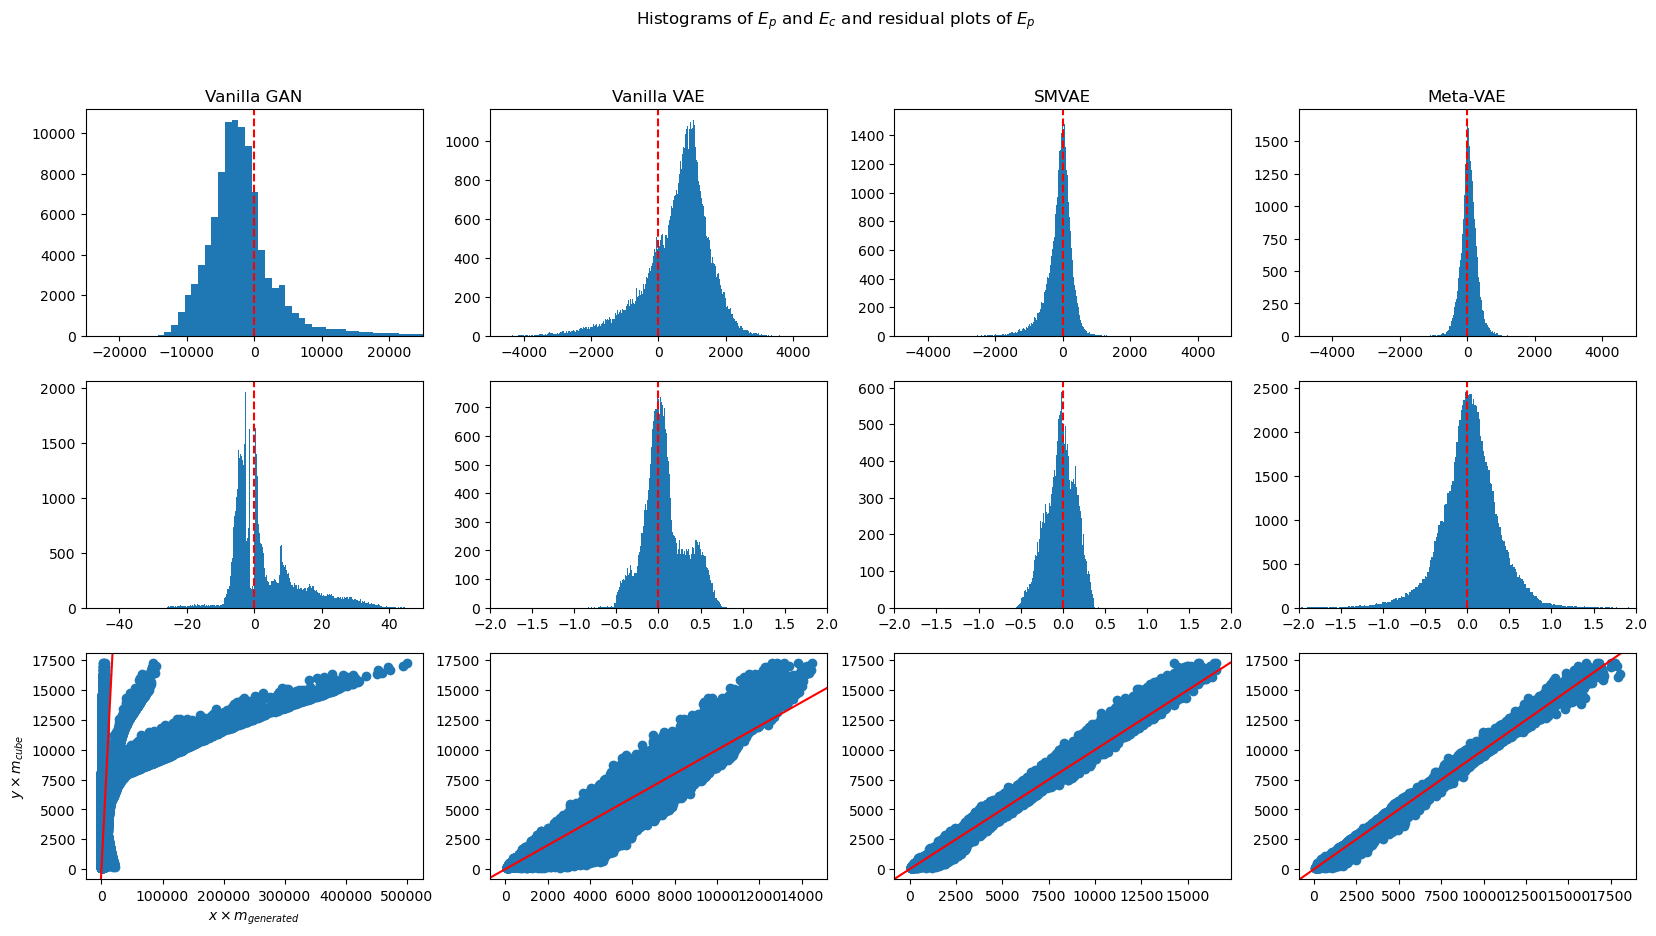

In [34]:
plot_errors()

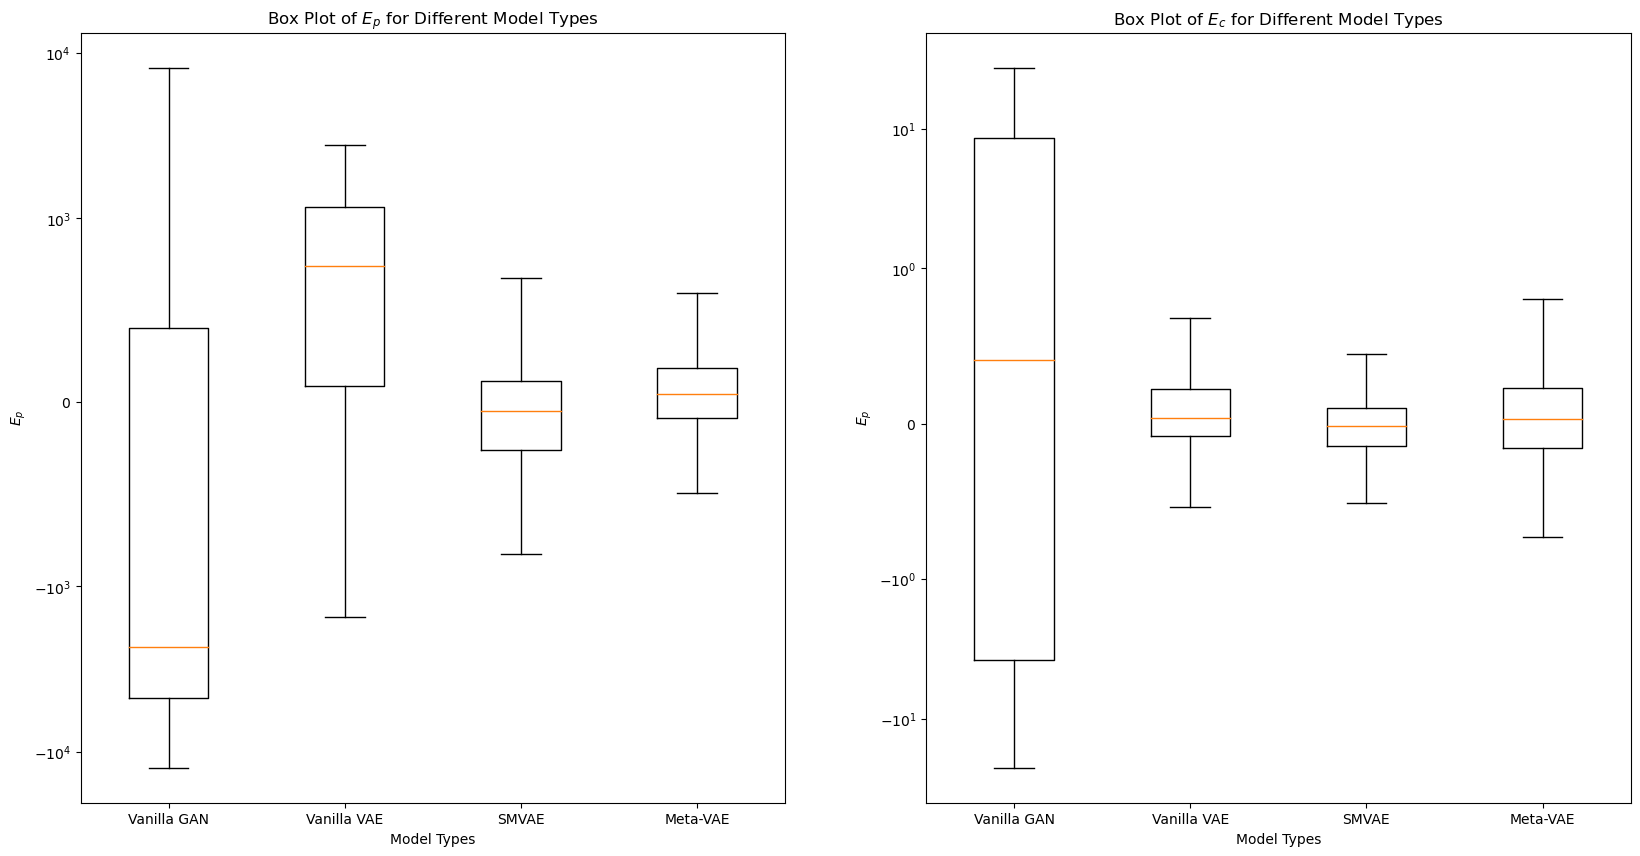

In [35]:
plot_box_plots(whis=1.5,linthresh=[1000,1])

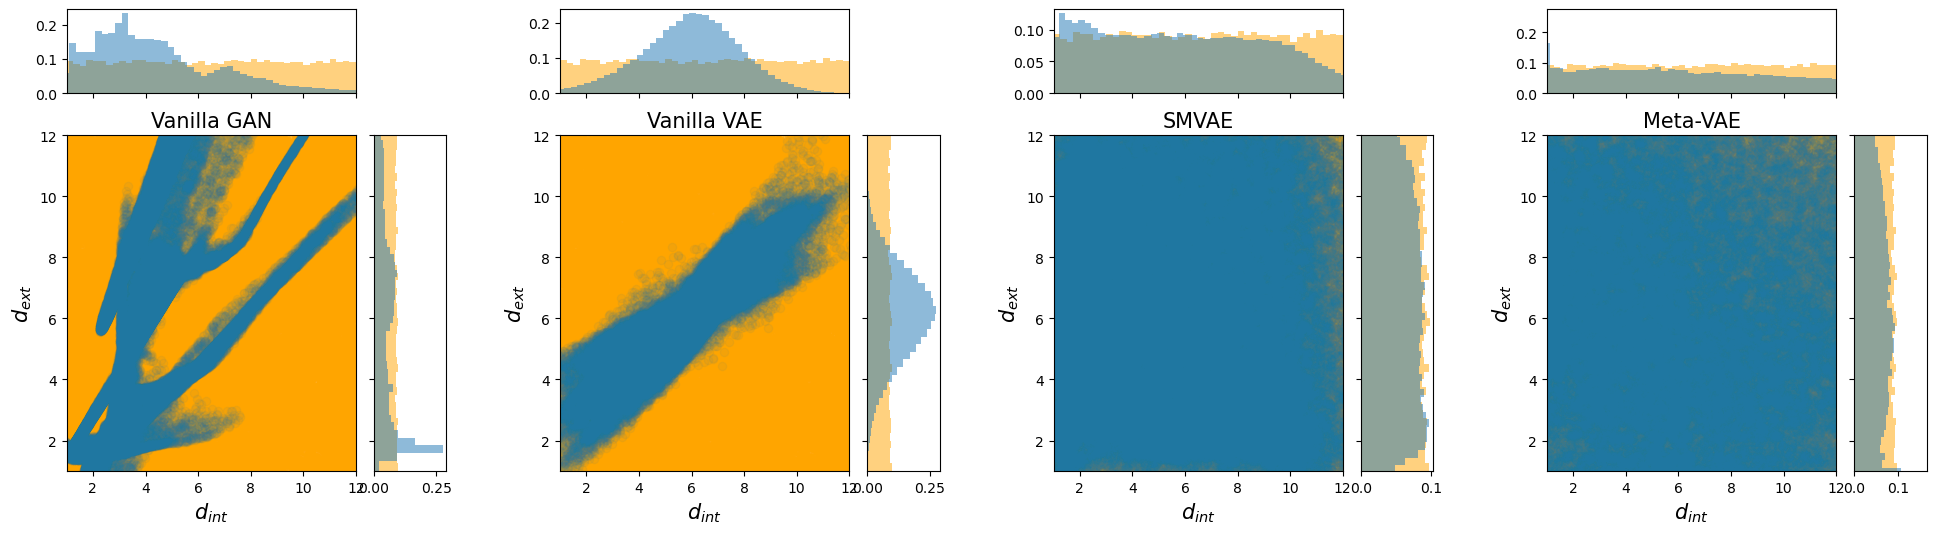

In [36]:
plot_joint_marginal_distributions('d1', 'd2', 'real_d1', 'real_d2',r'$d_{int}$',r'$d_{ext}$',(1,12),(1,12),.5)

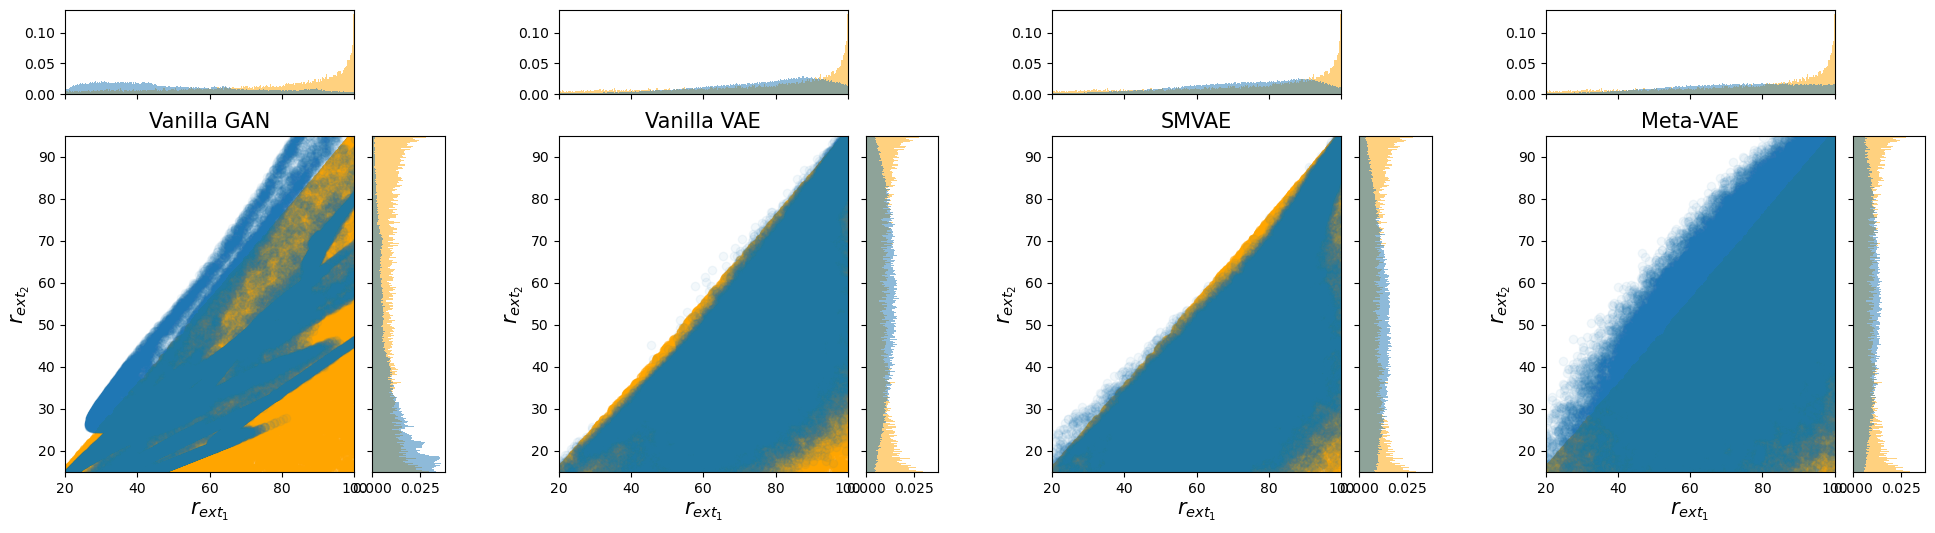

In [37]:
plot_joint_marginal_distributions('re1', 're2', 'real_re1', 'real_re2',r'$r_{ext_1}$',r'$r_{ext_2}$',(20,100),(15,95),.8)

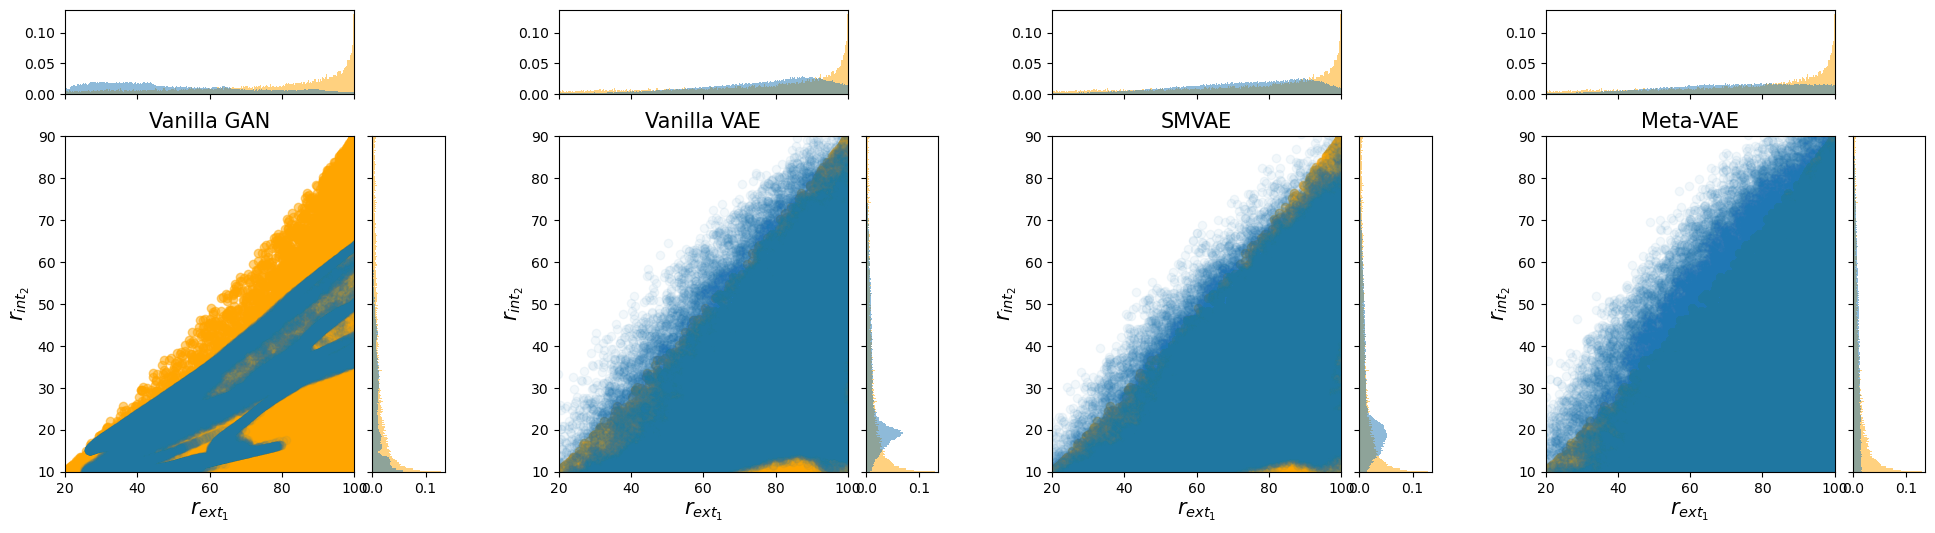

In [38]:
plot_joint_marginal_distributions('re1', 'ri2', 'real_re1', 'real_ri2',r'$r_{ext_1}$',r'$r_{int_2}$',(20,100),(10,90),.8)

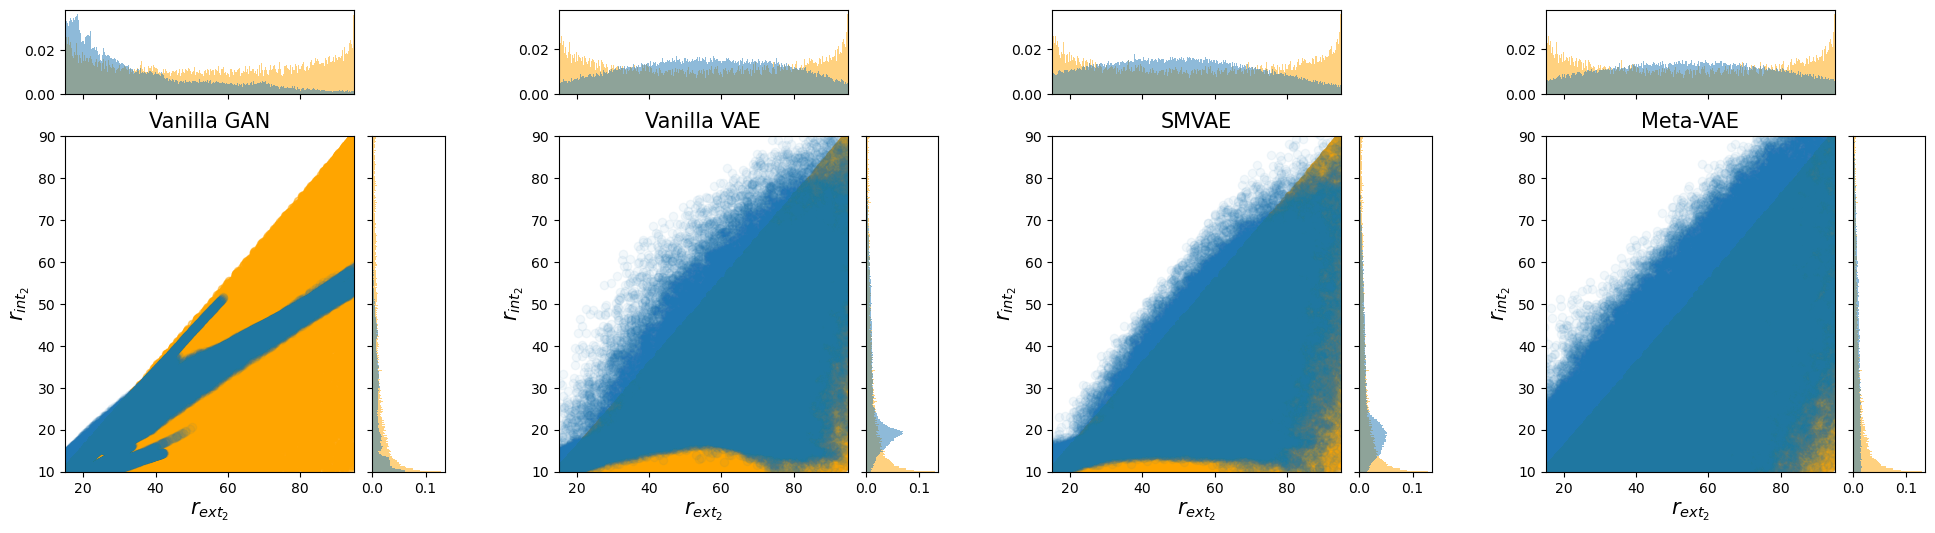

In [39]:
plot_joint_marginal_distributions('re2', 'ri2', 'real_re2', 'real_ri2',r'$r_{ext_2}$',r'$r_{int_2}$',(15,95),(10,90),.8)

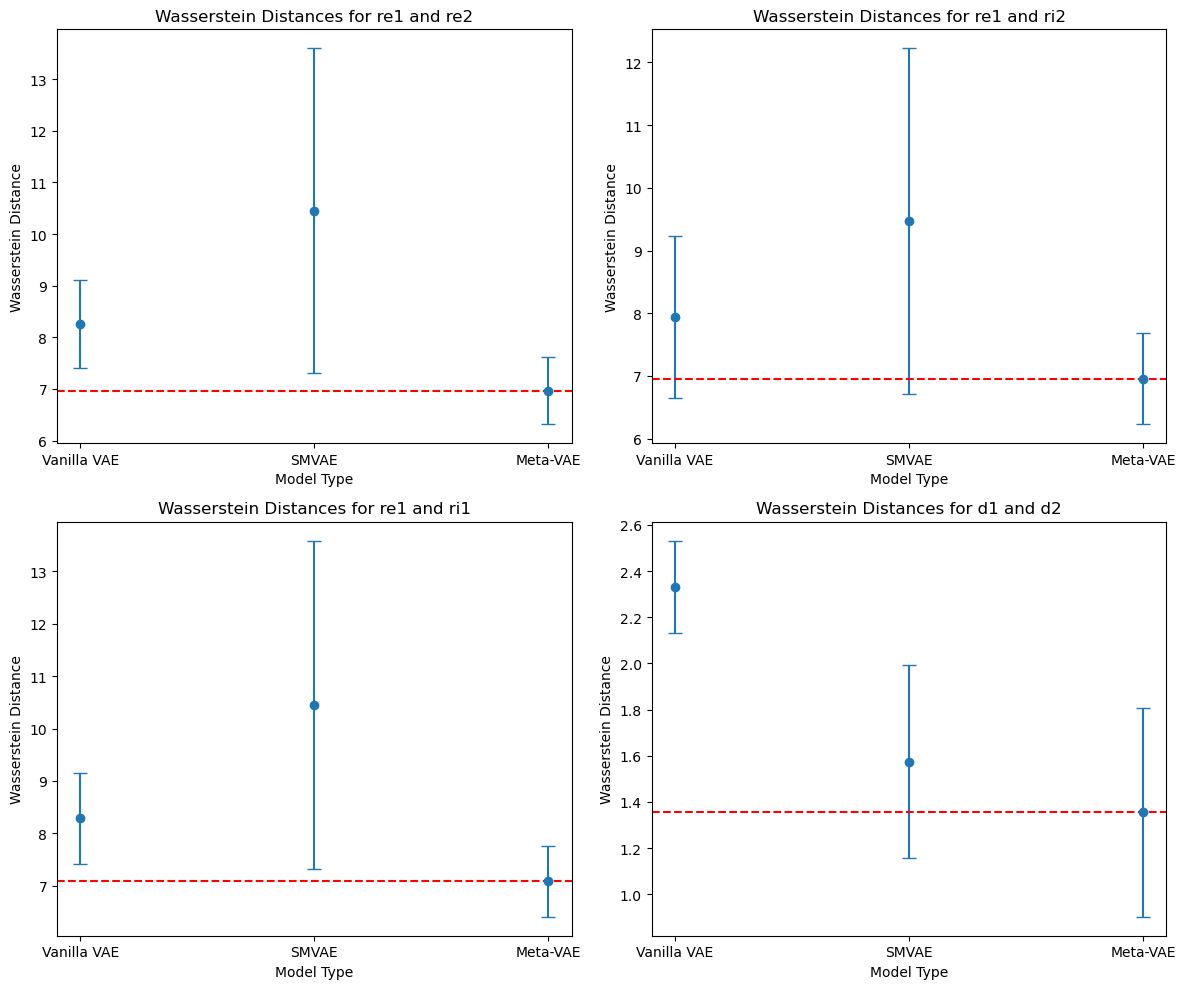

In [40]:
plot_wasserstein_errorbars(with_gan=False)

### Generations plots

Cylinders

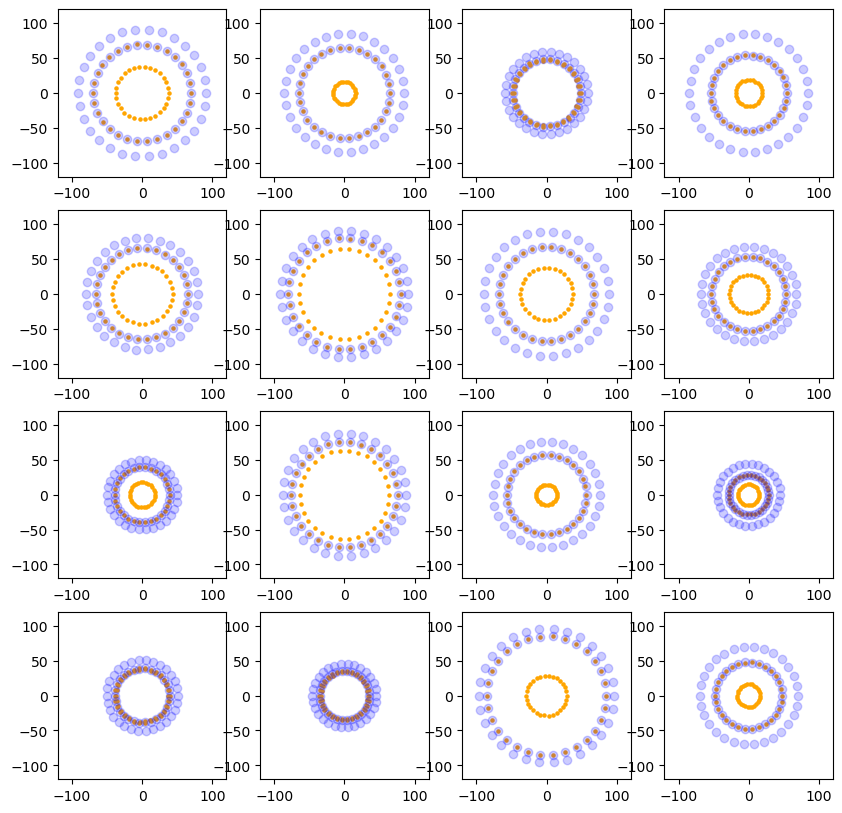

In [41]:
plot(svae_list[0],'svae')

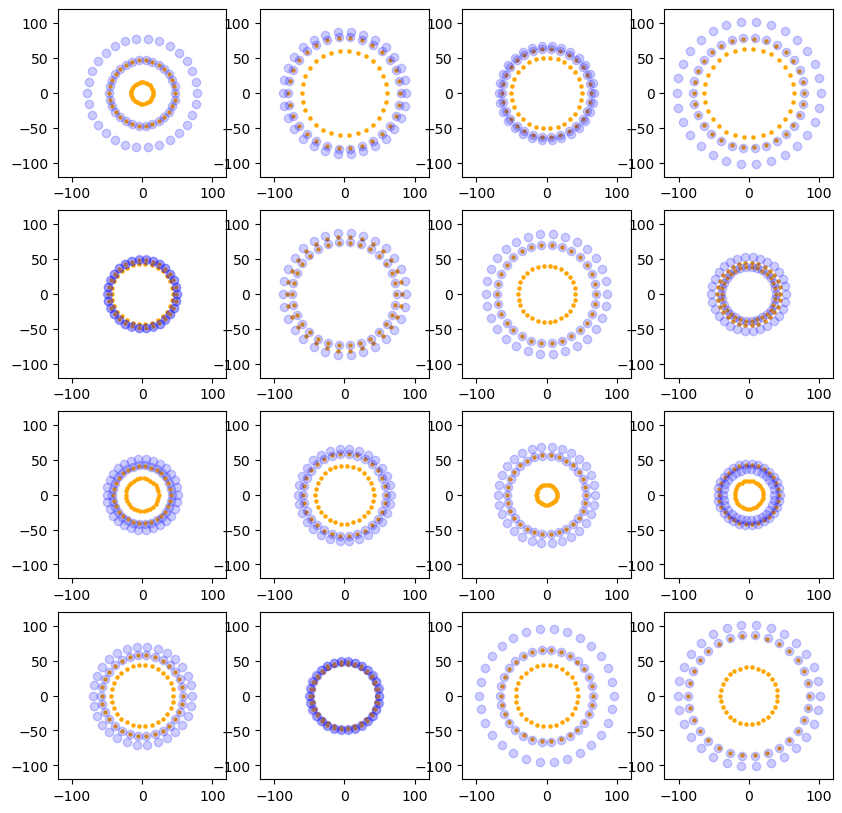

In [42]:
plot(mvae_list[0],'mvae')

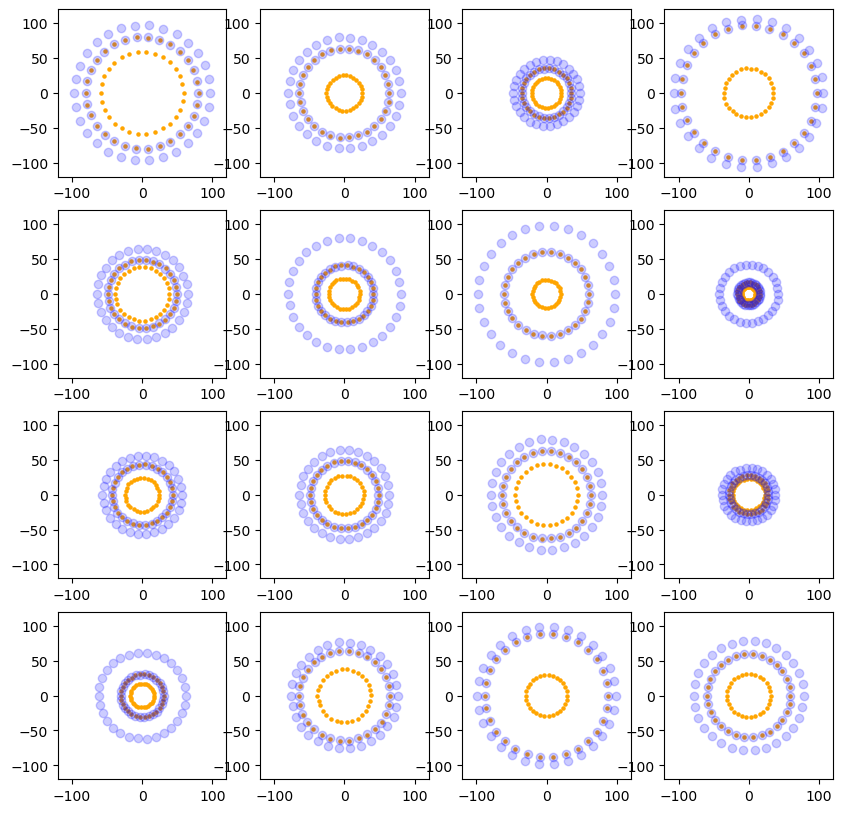

In [43]:
plot(vvae_list[0],'vvae')

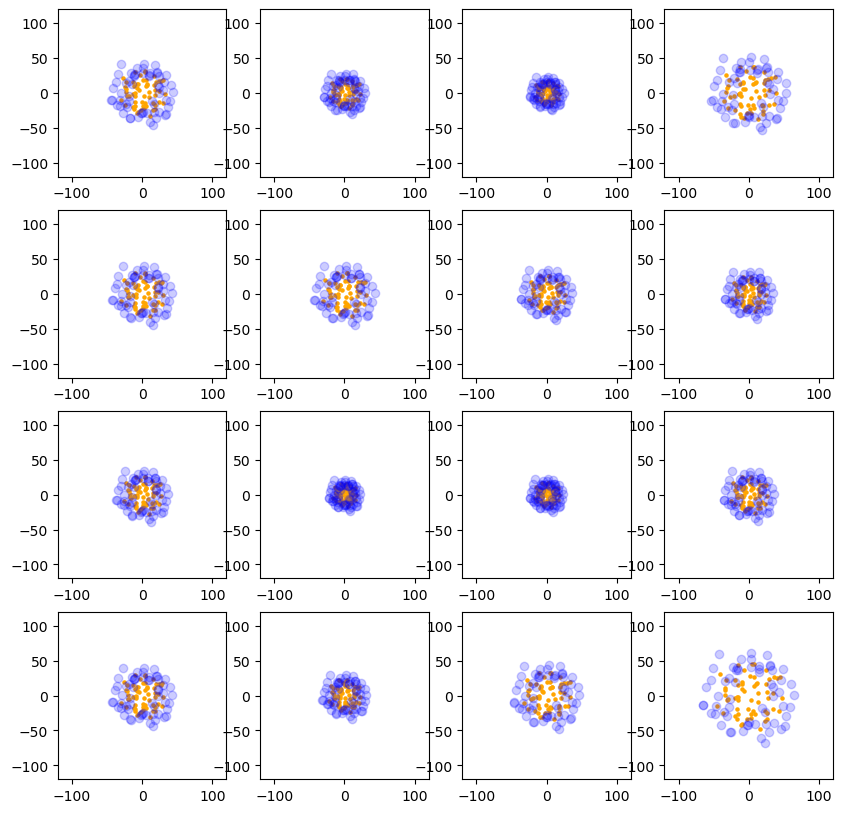

In [44]:
plot(gan_list[0],'gan')

Densities

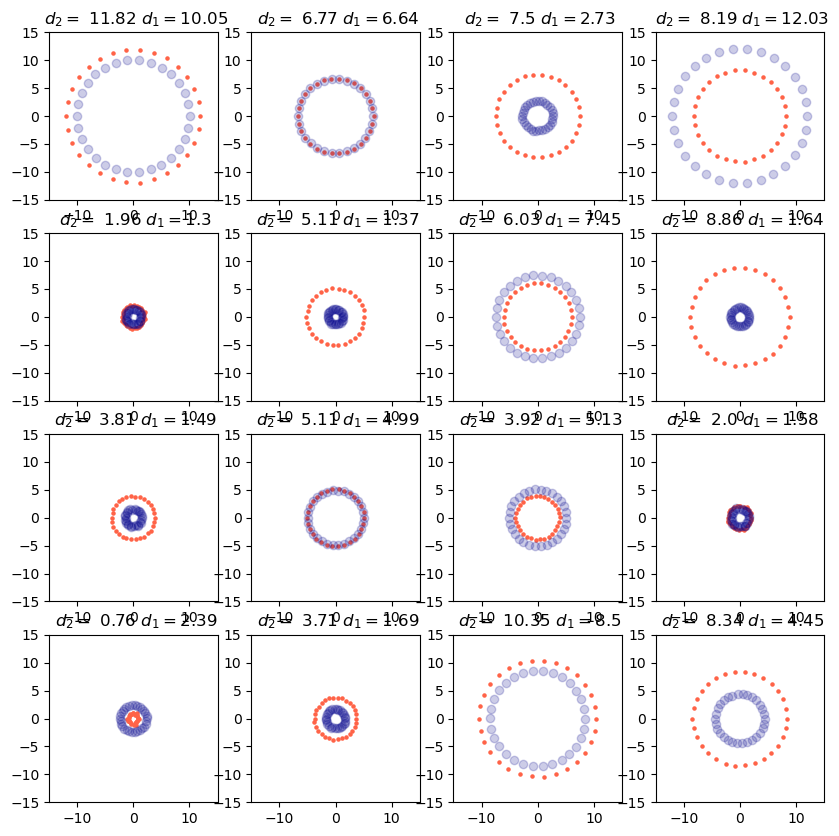

In [45]:
plot(svae_list[0],'svae',is_cylinders=False)

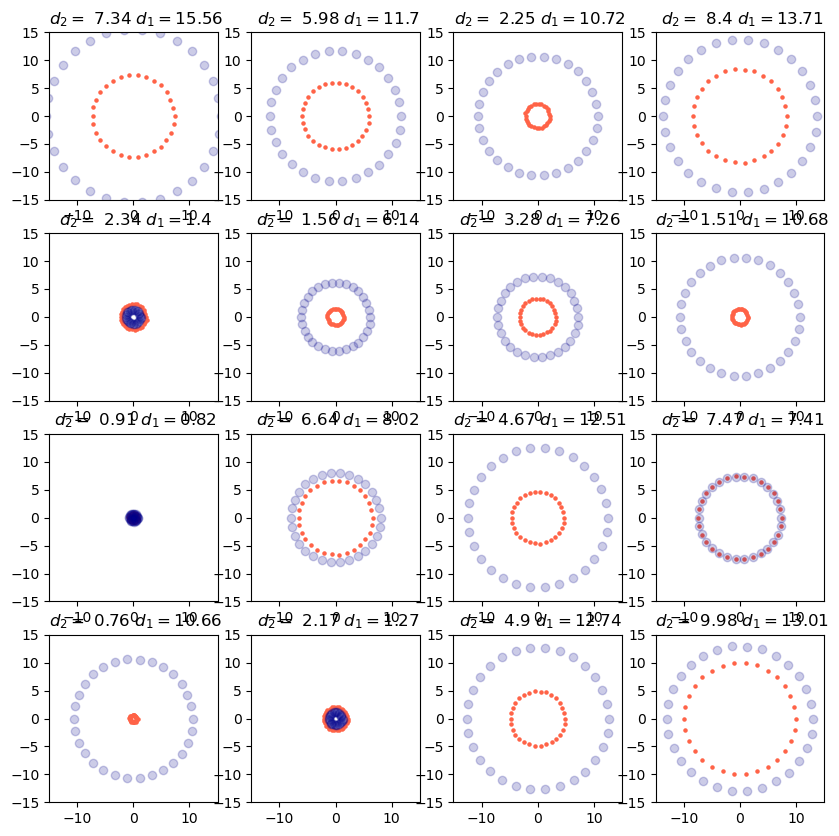

In [46]:
plot(mvae_list[0],'mvae',is_cylinders=False)

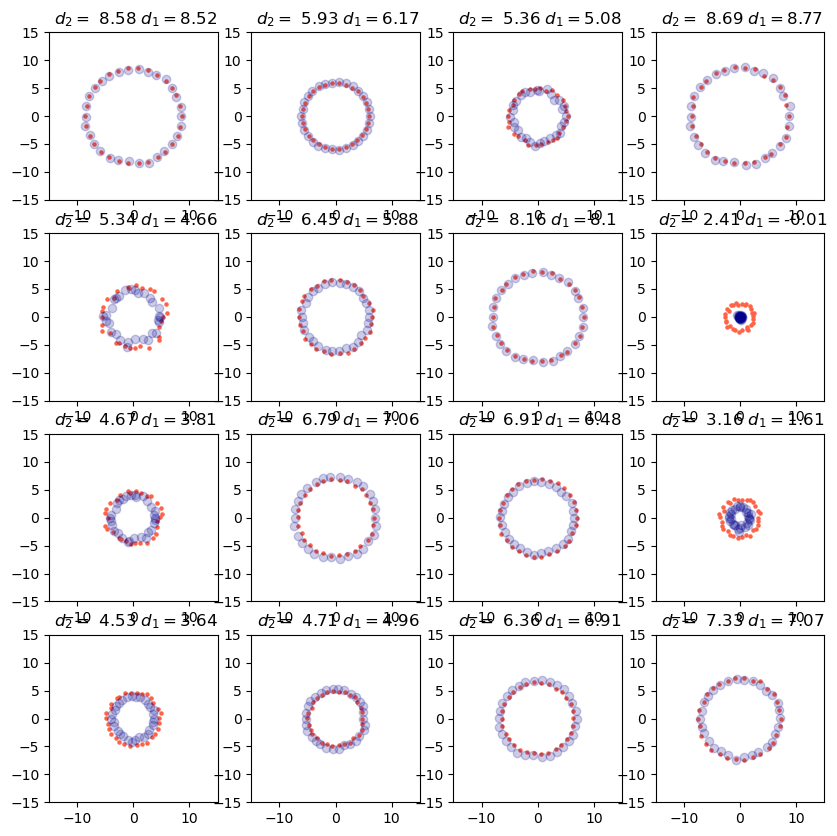

In [47]:
plot(vvae_list[0],'vvae',is_cylinders=False)

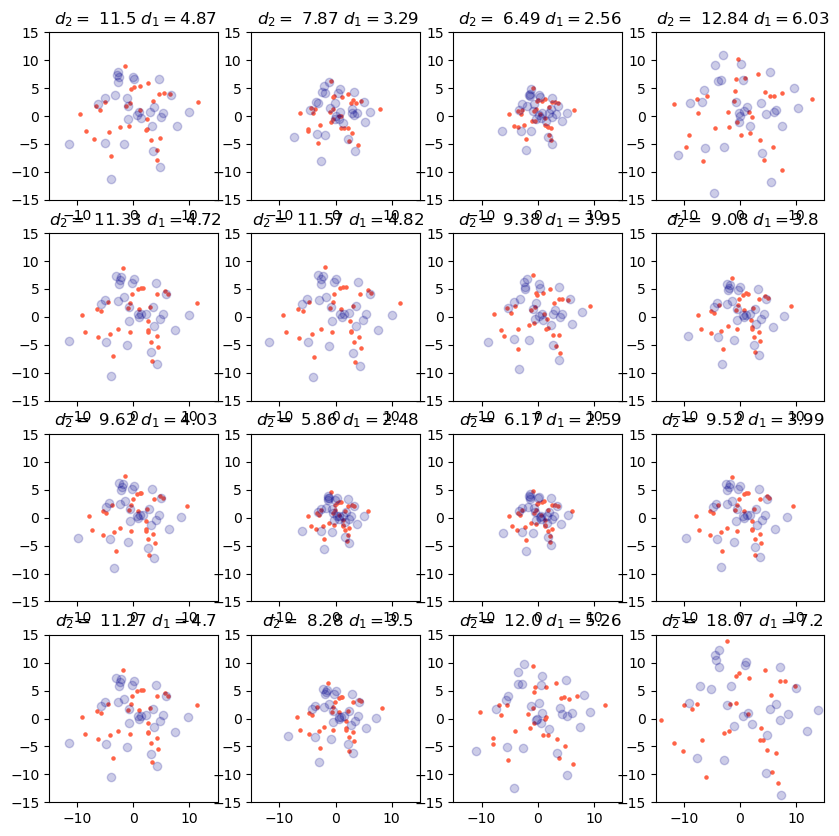

In [48]:
plot(gan_list[0],'gan',is_cylinders=False)